In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

In [3]:
import torch
from torch_geometric.utils import to_scipy_sparse_matrix

/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
%run setup_notebooks.py

In [5]:
from src import setup

In [6]:
import logging
logging.getLogger().setLevel(logging.INFO)

# Spectrum of Laplacians

In [13]:
path = setup.get_dataset_path('CoordToCnc')

2022-05-15 13:13:12,948 [setup] [INFO] get_data_path(): using user-defined data path


## Without weights

In [17]:
# Adjacency matrices
A_list = [
    to_scipy_sparse_matrix(torch.load(file).edge_index)
    for file in path.glob('*.pt')
]
len(A_list)

188

In [19]:
from graph_linalg import get_laplacian, get_laplacian_spectral_bounds

In [21]:
# Laplacians
L_list = [
    get_laplacian(A) for A in A_list
]

In [25]:
neigs = 5
eigs = [
    get_laplacian_spectral_bounds(L, n_eigs=neigs)
    for L in L_list
]

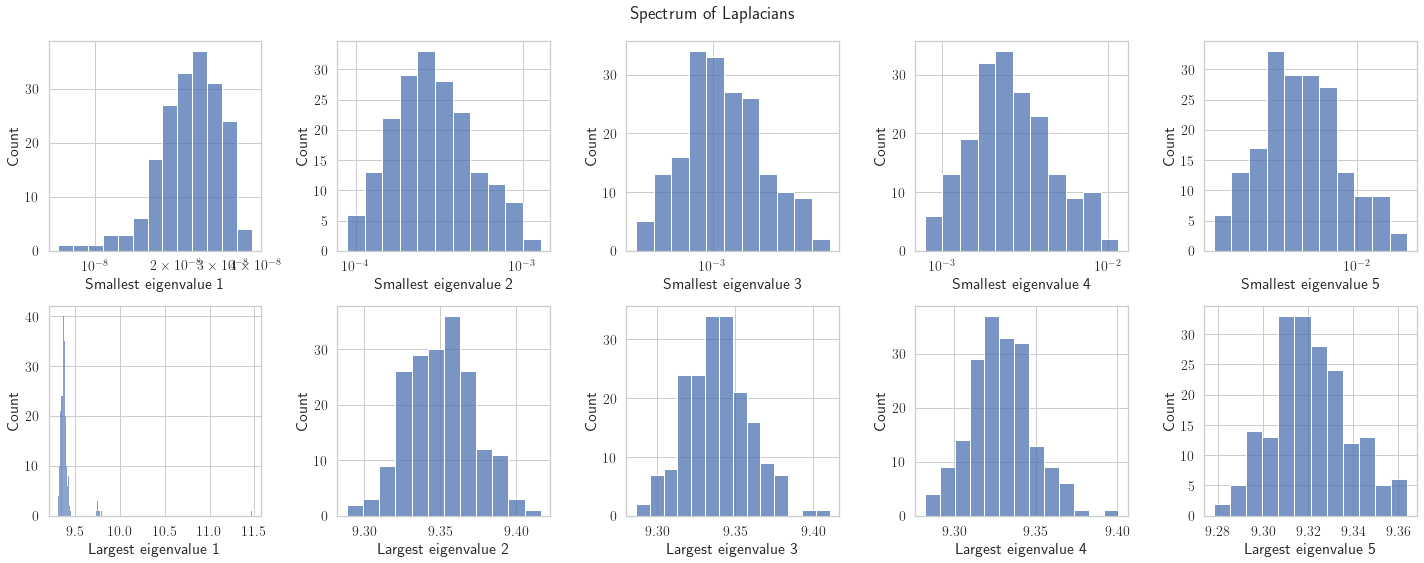

In [37]:
_, ax = plt.subplots(2, neigs, figsize=(neigs * 4, 8))

for i, a in enumerate(ax.T):
    min_eigs = np.array([e[0, i] for e in eigs])
    max_eigs = np.array([e[1, ::-1][i] for e in eigs])
    sns.histplot(min_eigs, ax=a[0], log_scale=True)
    sns.histplot(max_eigs, ax=a[1])
    a[0].set_xlabel(f'Smallest eigenvalue {i+1}')
    a[1].set_xlabel(f'Largest eigenvalue {i+1}')
    
plt.suptitle('Spectrum of Laplacians')
plt.tight_layout()

## With weights

In [38]:
from data_augmentation import add_edge_weights

In [72]:
data = [
    add_edge_weights(torch.load(file)) for file in path.glob('*.pt')
]

L_list = [
    get_laplacian(to_scipy_sparse_matrix(e.edge_index, edge_attr=e.edge_weight))
    for e in data
]

In [73]:
neigs = 5
eigs = [
    get_laplacian_spectral_bounds(L, n_eigs=neigs)
    for L in L_list
]

In [79]:
eigs[0][0, :]

array([7.4505806e-09, 1.0198131e-03, 3.8696527e-03, 8.8864043e-03,
       1.5591778e-02], dtype=float32)

i=0, 23 zero eigs discarded from viz
i=1, 0 zero eigs discarded from viz
i=2, 0 zero eigs discarded from viz
i=3, 0 zero eigs discarded from viz
i=4, 0 zero eigs discarded from viz


/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


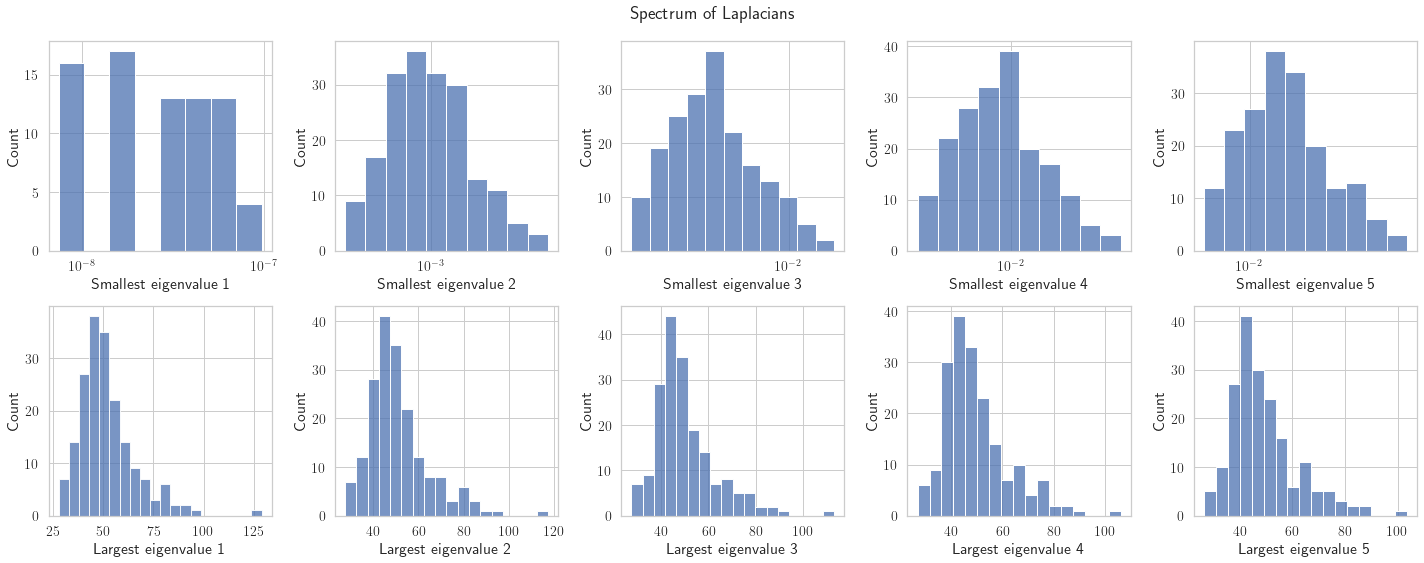

In [76]:
_, ax = plt.subplots(2, neigs, figsize=(neigs * 4, 8))

for i, a in enumerate(ax.T):
    min_eigs = np.array([e[0, i] for e in eigs])
    max_eigs = np.array([e[1, ::-1][i] for e in eigs])
    mask = min_eigs != 0
    min_eigs = min_eigs[mask]
    print(f'i={i}, {(~mask).sum()} zero eigs discarded from viz')
    
    sns.histplot(min_eigs, ax=a[0], log_scale=True)
    sns.histplot(max_eigs, ax=a[1])
    a[0].set_xlabel(f'Smallest eigenvalue {i+1}')
    a[1].set_xlabel(f'Largest eigenvalue {i+1}')
    
plt.suptitle('Spectrum of Laplacians')
plt.tight_layout()

# Analyze graph features

In [82]:
path = setup.get_dataset_path('perimeters_graph_features')
data = torch.load(path.joinpath('graph_features.pt'))

2022-05-15 14:23:07,773 [setup] [INFO] get_data_path(): using user-defined data path


In [84]:
data.keys()

dict_keys(['input_dset', 'tau0', 'kmax', 'features'])

In [85]:
data['input_dset'], data['tau0'], data['kmax']

('CoordToCnc_perimeter', 0.01, 10)

In [97]:
index, df = [], []
for key, val in data['features'].items():
    index.append(key)
    df.append(val.numpy().flatten())

df = pd.DataFrame(df, index)
df

,0,1,2,3,4,5,6,7,8,9,10
OLV035_LCX,614.603943,456.317383,463.026978,470.484985,478.891266,488.524170,499.779358,513.231628,529.734863,550.586792,577.805786
OLV029_LCX,1392.777222,1197.873413,1210.596436,1224.166748,1238.732300,1254.478149,1271.638672,1290.512573,1311.484009,1335.051392,1361.865967
OLV050_RCA,482.527679,349.447662,355.938141,363.046143,370.925476,379.786804,389.922699,401.745636,415.844757,433.073090,454.681000
CHUV15_LCX,326.681824,245.748367,249.204071,252.983414,257.173859,261.901886,267.356873,273.833801,281.811707,292.104279,306.160004
CHUV06_LAD,696.342773,545.346252,552.322327,559.941956,568.371704,577.846680,588.707642,601.463318,616.896912,636.253418,661.577942
...,...,...,...,...,...,...,...,...,...,...,...
OLV011_LAD,798.788208,664.087952,671.306274,679.064575,687.493713,696.775757,707.170227,719.056152,733.000732,749.876099,771.059448
OLV004_RCA,625.215942,476.781281,484.135834,492.168396,501.040619,510.973938,522.278198,535.397034,550.980347,570.003113,593.963257
FRH013_RCA,864.620972,659.041321,669.794189,681.533386,694.480530,708.930176,725.279602,744.073486,766.070251,792.343872,824.440491
OLV048_LAD,560.852173,436.790436,442.710083,449.203644,456.416992,464.550079,473.881744,484.807281,497.897308,513.989929,534.338501


In [99]:
path, _ = setup.get_data_paths()
path_labels = path.joinpath('CFD/labels')
df_labels = pd.read_excel(path_labels.joinpath('WSSdescriptors_AvgValues.xlsx'), engine='openpyxl')
df_labels

2022-05-15 14:29:23,595 [setup] [INFO] get_data_path(): using user-defined data path


,Code,TAWSS,OSI,RRT,transWSS,CFI,TAWSSax,TAWSSsc,WSSratio,TSVI,FC
0,CHUV01_LAD,3.64717,0.014050,0.846456,0.073336,0.057265,3.58750,0.158997,0.176172,228.3910,0
1,CHUV01_LCX,2.55975,0.003294,0.611145,0.055230,0.040732,2.48901,0.337315,0.290763,86.0399,1
2,CHUV02_LAD,2.63011,0.005814,0.582346,0.056851,0.040757,2.59072,0.225770,0.202236,60.5216,1
3,CHUV02_LCX,2.98097,0.000154,0.373309,0.039946,0.014991,2.95874,0.257049,0.077637,22.2836,0
4,CHUV02_RCA,2.43675,0.006072,0.583699,0.098474,0.056273,2.29555,0.589120,0.467824,60.5002,0
...,...,...,...,...,...,...,...,...,...,...,...
183,OLV048_LCX,2.53027,0.000036,0.407267,0.017071,0.007672,2.52312,0.127840,0.048128,10.4213,0
184,OLV049_LAD,2.86934,0.010788,0.673836,0.028470,0.035946,2.84023,0.160913,0.326003,102.0050,1
185,OLV049_RCA,2.09383,0.001343,0.756832,0.034190,0.030094,2.02367,0.213538,0.165229,39.1061,0
186,OLV050_LCX,2.82282,0.000498,0.409097,0.058604,0.025448,2.76545,0.386589,0.137708,33.7438,1


In [100]:
df = df.join(df_labels.set_index('Code').FC)
df

,0,1,2,3,4,5,6,7,8,9,10,FC
OLV035_LCX,614.603943,456.317383,463.026978,470.484985,478.891266,488.524170,499.779358,513.231628,529.734863,550.586792,577.805786,0
OLV029_LCX,1392.777222,1197.873413,1210.596436,1224.166748,1238.732300,1254.478149,1271.638672,1290.512573,1311.484009,1335.051392,1361.865967,0
OLV050_RCA,482.527679,349.447662,355.938141,363.046143,370.925476,379.786804,389.922699,401.745636,415.844757,433.073090,454.681000,0
CHUV15_LCX,326.681824,245.748367,249.204071,252.983414,257.173859,261.901886,267.356873,273.833801,281.811707,292.104279,306.160004,1
CHUV06_LAD,696.342773,545.346252,552.322327,559.941956,568.371704,577.846680,588.707642,601.463318,616.896912,636.253418,661.577942,1
...,...,...,...,...,...,...,...,...,...,...,...,...
OLV011_LAD,798.788208,664.087952,671.306274,679.064575,687.493713,696.775757,707.170227,719.056152,733.000732,749.876099,771.059448,1
OLV004_RCA,625.215942,476.781281,484.135834,492.168396,501.040619,510.973938,522.278198,535.397034,550.980347,570.003113,593.963257,1
FRH013_RCA,864.620972,659.041321,669.794189,681.533386,694.480530,708.930176,725.279602,744.073486,766.070251,792.343872,824.440491,0
OLV048_LAD,560.852173,436.790436,442.710083,449.203644,456.416992,464.550079,473.881744,484.807281,497.897308,513.989929,534.338501,1


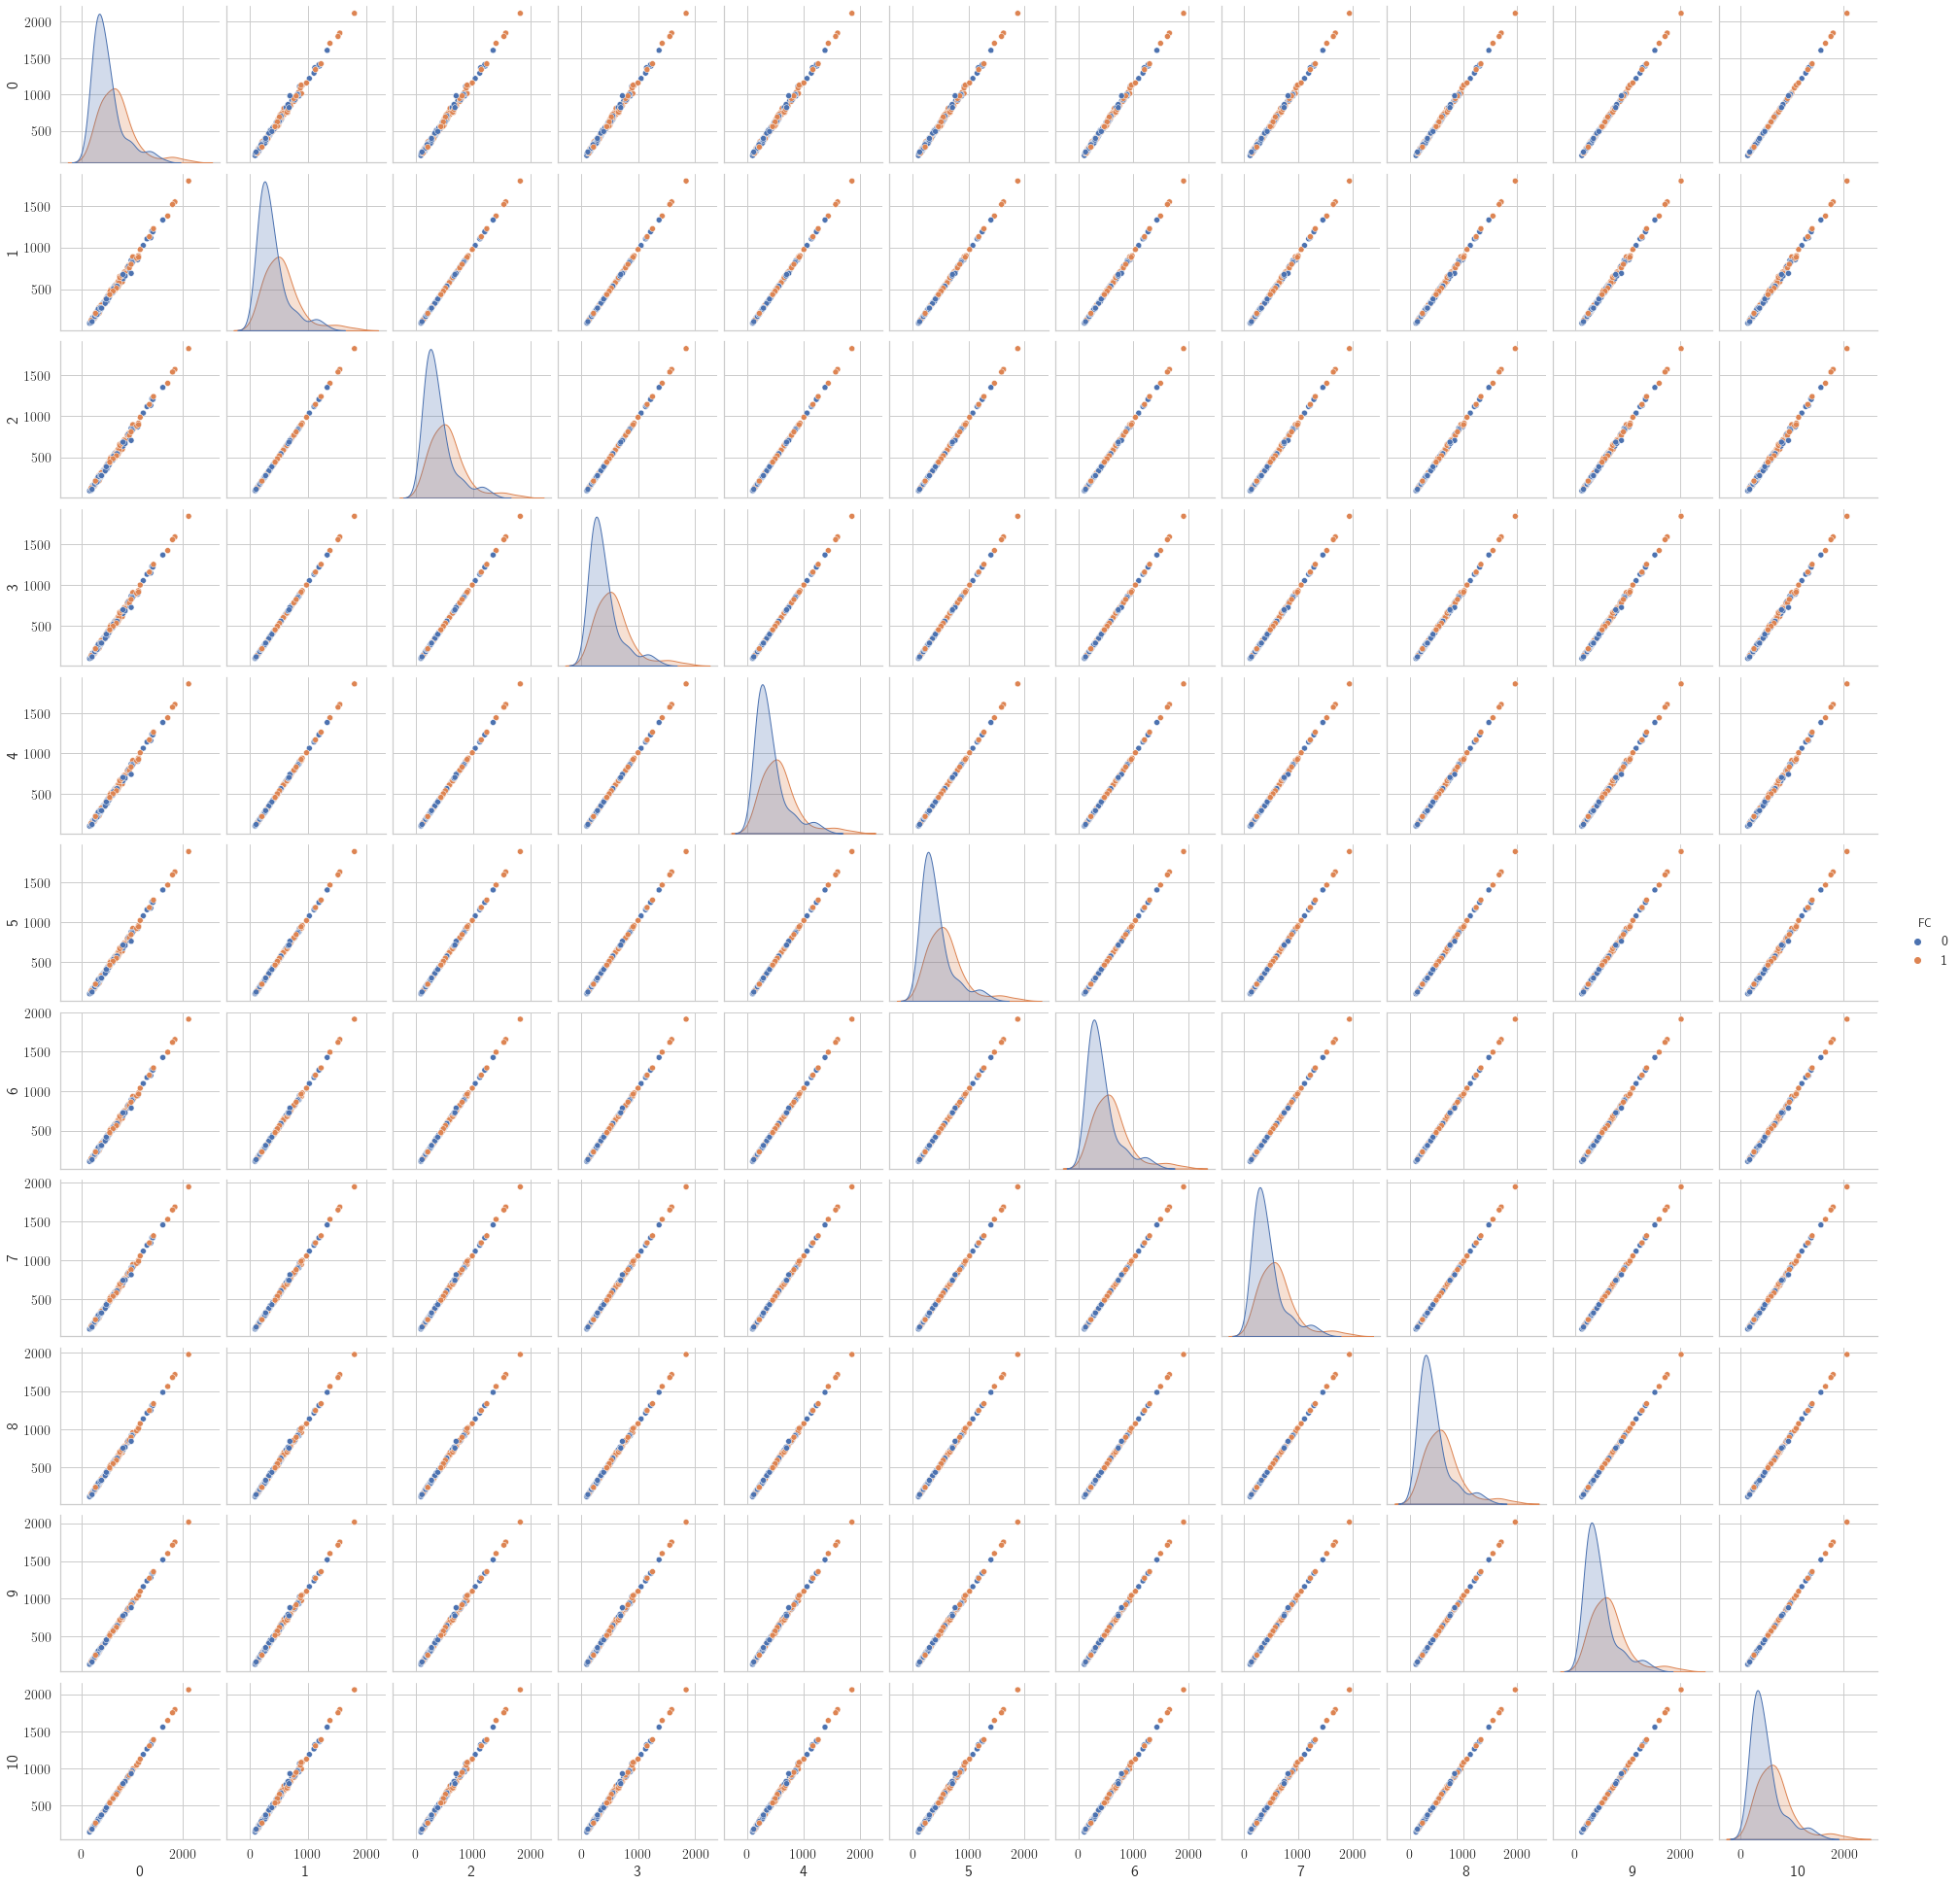

In [122]:
sns.pairplot(data=df, hue='FC')

In [116]:
df_test = df.drop(columns='FC')
min_ = df_test.values.min(axis=1)
max_ = df_test.values.max(axis=1)
values = (df_test.values - min_[:, None]) / (max_[:, None] - min_[:, None])
df_test = pd.DataFrame(data=values, index=df_test.index, columns=df_test.columns)
df_test = df_test.join(df_labels.set_index('Code').FC)
df_test

,0,1,2,3,4,5,6,7,8,9,10,FC
OLV035_LCX,1.0,0.0,0.042389,0.089506,0.142614,0.203471,0.274578,0.359565,0.463826,0.595562,0.767522,0
OLV029_LCX,1.0,0.0,0.065278,0.134904,0.209636,0.290424,0.378470,0.475307,0.582906,0.703824,0.841403,0
OLV050_RCA,1.0,0.0,0.048771,0.102183,0.161390,0.227977,0.304141,0.392981,0.498926,0.628385,0.790752,0
CHUV15_LCX,1.0,0.0,0.042698,0.089395,0.141171,0.199590,0.266991,0.347019,0.445592,0.572766,0.746436,1
CHUV06_LAD,1.0,0.0,0.046200,0.096663,0.152490,0.215240,0.287168,0.371645,0.473856,0.602048,0.769764,1
...,...,...,...,...,...,...,...,...,...,...,...,...
OLV011_LAD,1.0,0.0,0.053588,0.111185,0.173762,0.242671,0.319838,0.408078,0.511601,0.636882,0.794145,1
OLV004_RCA,1.0,0.0,0.049547,0.103663,0.163434,0.230355,0.306511,0.394893,0.499877,0.628033,0.789452,1
FRH013_RCA,1.0,0.0,0.052305,0.109408,0.172387,0.242674,0.322203,0.413622,0.520620,0.648423,0.804550,0
OLV048_LAD,1.0,0.0,0.047715,0.100057,0.158200,0.223757,0.298975,0.387040,0.492552,0.622267,0.786286,1


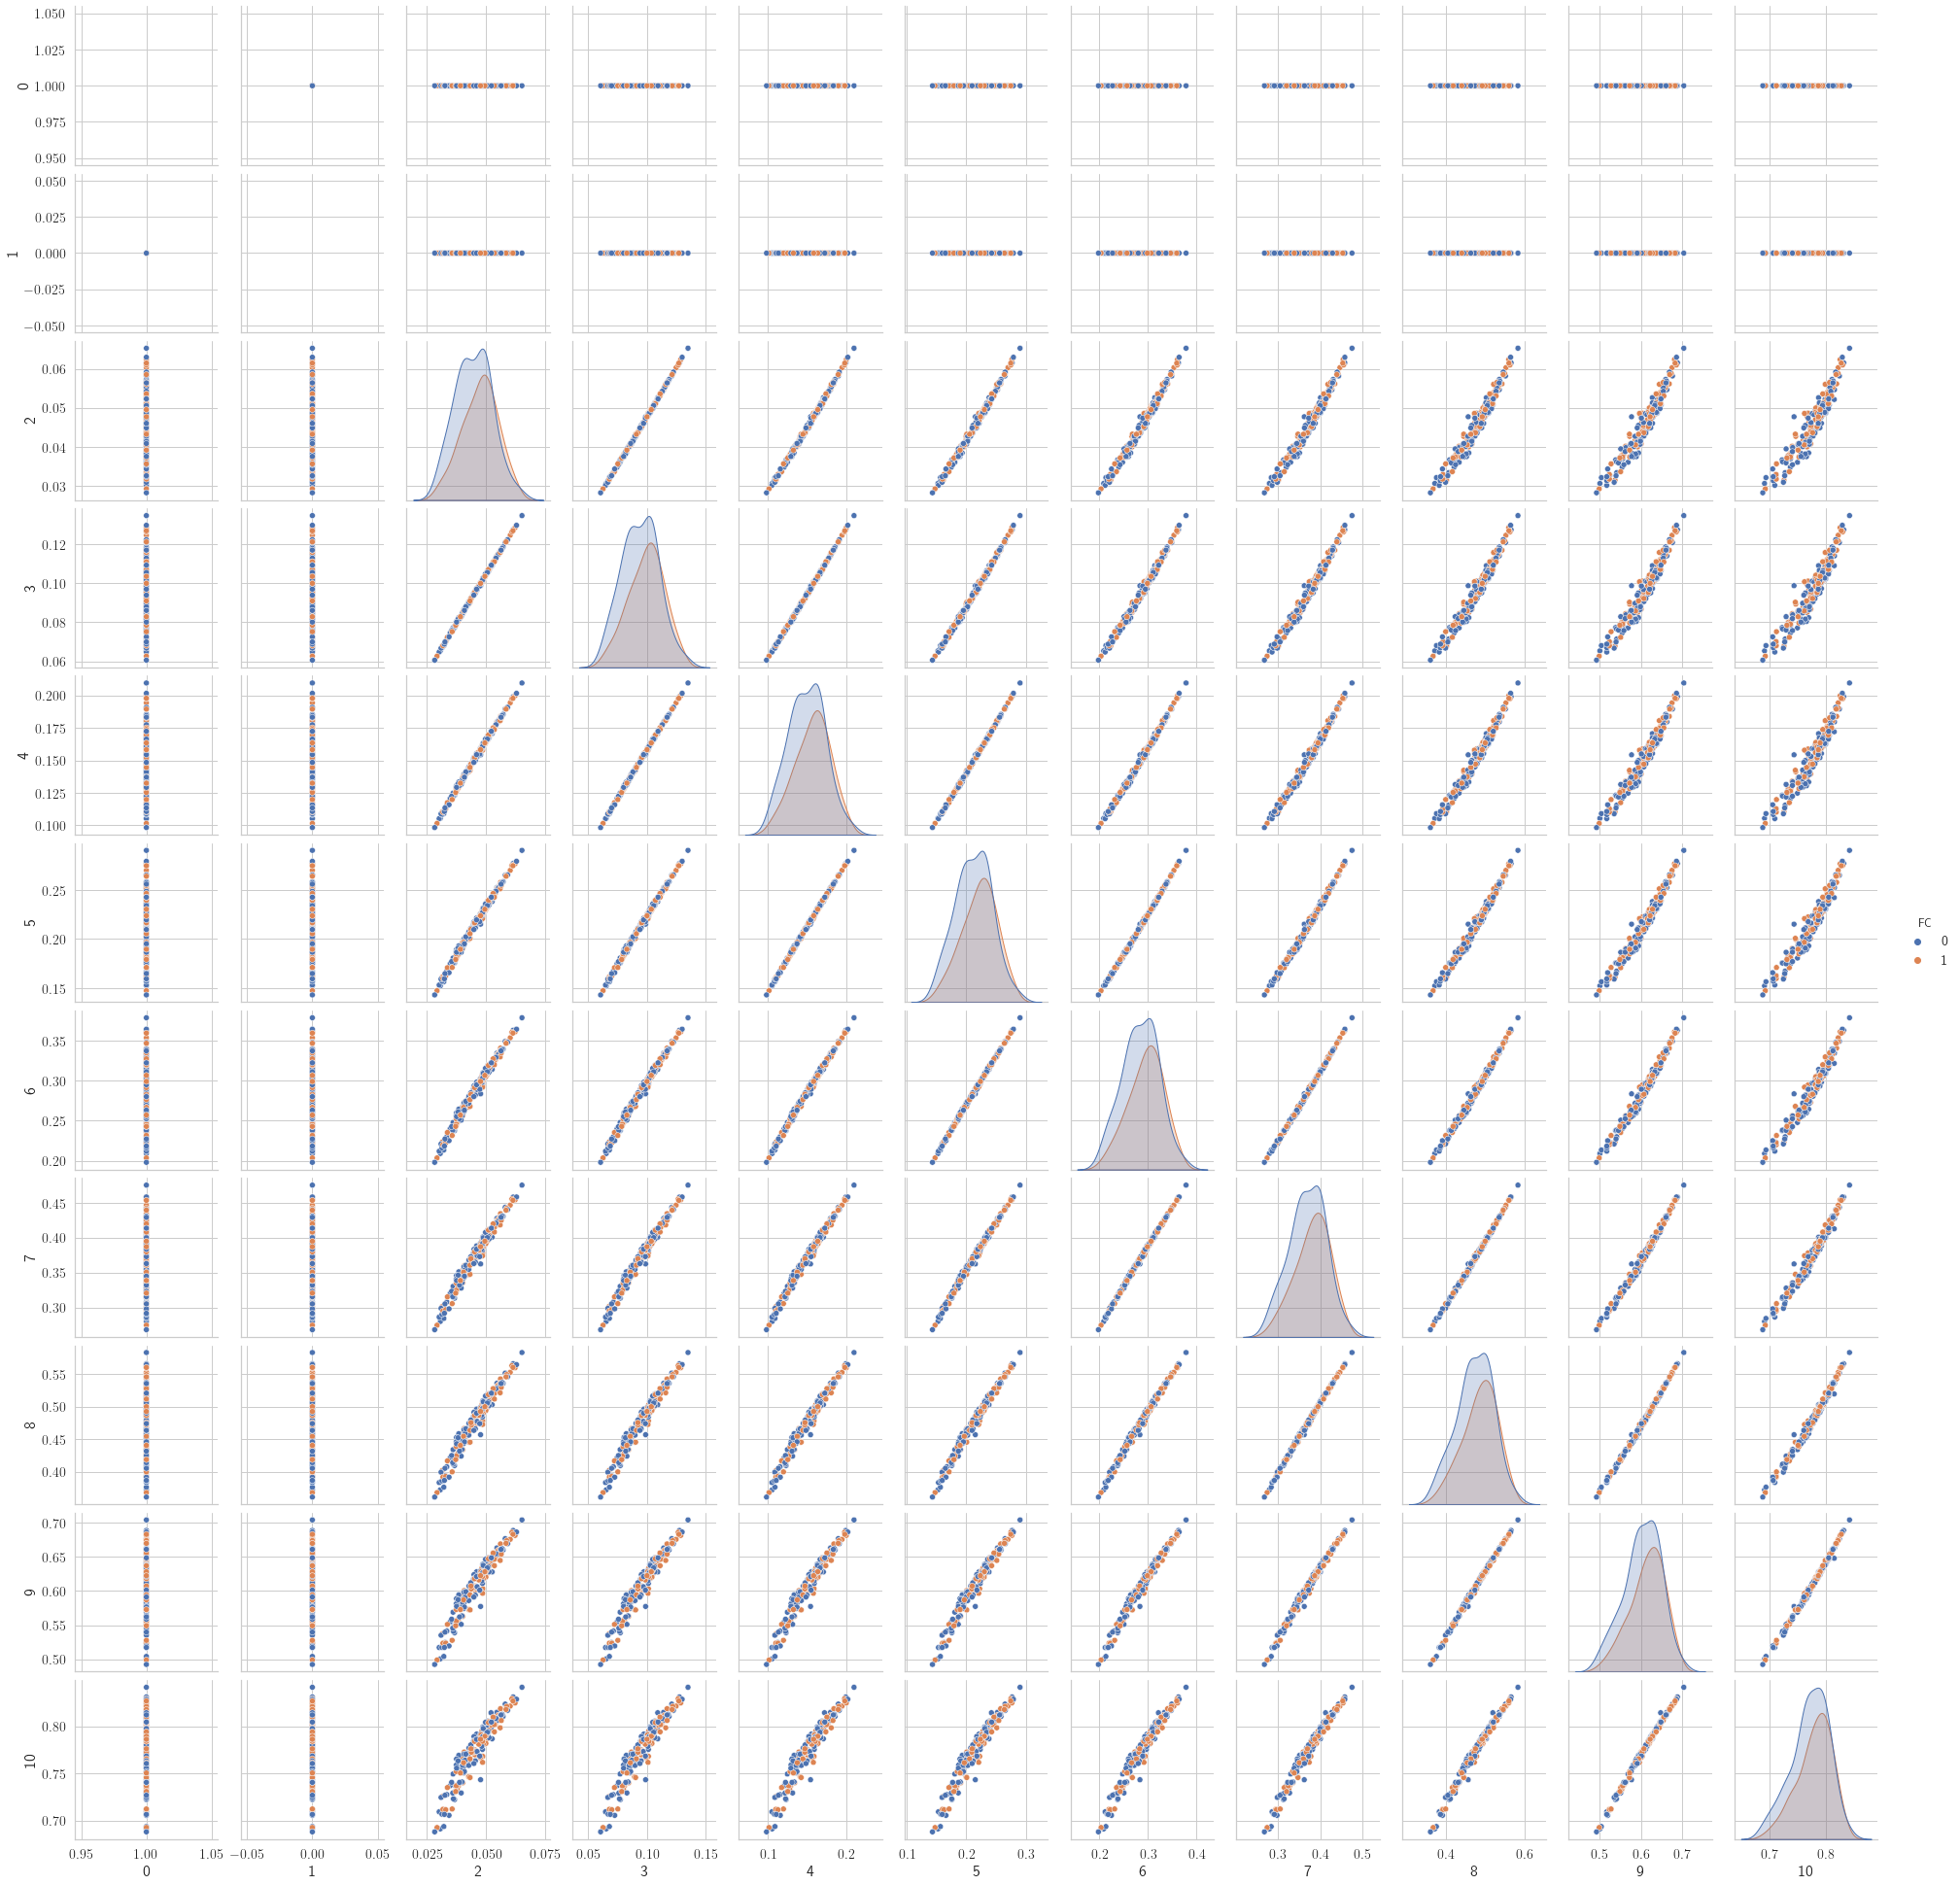

In [121]:
sns.pairplot(data=df_test, hue='FC')

<AxesSubplot:xlabel='5', ylabel='Count'>

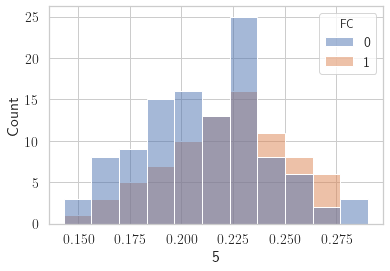

In [120]:
sns.histplot(x=5, data=df_test, hue='FC')

---

In [8]:
path = setup.get_dataset_path('perimeters_graph_features')

2022-05-15 12:49:28,914 [setup] [INFO] get_data_path(): using user-defined data path


In [11]:
!ls $path

graph_features.json  graph_features.pt


In [12]:
data = torch.load(path.joinpath('graph_features.pt'))
data

{'input_dset': 'CoordToCnc_perimeters',
 'tau0': 0.1,
 'kmax': 5,
 'features': {'CHUV01_LAD': tensor([[531.5146],
          [319.3246],
          [337.5268],
          [358.7674],
          [384.8943],
          [421.7742]])}}